# Lab Project on Fine-Tuning Language Models  
## Advanced Natural Language Processing Course  
**University Year:** 2024/2025  

### Group Members  
- Aya Karbich  
- Malak Agadi  
- Hajar Essaadi  
- Hafsa Ladhase  
- Oumaima Ziat  

### Supervisor  
**Professor:** Youness Moukafih  

---

### Project Objectives  
1. **Fine-Tuning the Target Model**  
   - Fine-tune a pre-trained BERT model on the `Arabic Sentiment Tweets` dataset.  
   - Evaluate the model's performance on the test dataset using metrics from [TorchMetrics](https://lightning.ai/docs/torchmetrics/stable/all-metrics.html).  

2. **Implementing Multi-Head Differential Attention**  
   - Develop a custom multi-head attention class based on differential attention.  
   - Integrate this class into the fine-tuned BERT model.  

3. **Experimenting with Hybrid Attention Mechanisms**  
   - Replace 25%-50% of the encoder and/or decoder layers’ multi-head attention with multi-head differential attention.  
   - Train the modified models and assess their performance for each configuration.  

---

### Dataset  
**Name:** Arabic Sentiment Tweets Dataset  
- **Task:** Text Classification  
- **Dataset Link:** [Mendeley Data](https://data.mendeley.com/datasets/57zpx667y9/2)  

### Pre-trained Model  
**Model:** BERT  
- **Pre-trained Version:** [BERT-Base-ArabertV2](https://huggingface.co/aubmindlab/bert-base-arabertv2)  


   





#**1. Loading the Dataset**

In [4]:
import zipfile
import os

zip_path = "/content/SANAD_SUBSET.zip"
extract_path = "/content/SANAD"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted SANAD_SUBSET to {extract_path}")

Extracted SANAD_SUBSET to /content/SANAD


In [5]:
import os

# Paths to the dataset folders
base_path = "/content/SANAD"
train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")

# Function to load data
def load_data_from_folder(folder_path):
    data = []
    labels = []
    for label in os.listdir(folder_path):  # Each folder is a category (label: Culture, Finance...)
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):  # Ensure it's a folder
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)
                with open(file_path, 'r', encoding='utf-8') as file:
                    data.append(file.read())
                    labels.append(label)
    return data, labels

# Load Train and Test data
train_data, train_labels = [], []
test_data, test_labels = [], []

for dataset_folder in ["akhbarona", "khaleej", "arabiya"]:
    # Load train data
    train_folder = os.path.join(base_path, dataset_folder, "Train")
    data, labels = load_data_from_folder(train_folder)
    train_data.extend(data)
    train_labels.extend(labels)

    # Load test data
    test_folder = os.path.join(base_path, dataset_folder, "Test")
    data, labels = load_data_from_folder(test_folder)
    test_data.extend(data)
    test_labels.extend(labels)

print(f"Loaded {len(train_data)} training samples and {len(test_data)} testing samples.")

Loaded 99810 training samples and 11090 testing samples.


### Progress So Far:
We have successfully loaded and merged the SANAD dataset, which contains three subsets: `Akhbarona`, `Khaleej`, and `Arabiya`. Each subset was divided into training and testing sets. After merging the data, we verified the label distribution across the training and testing sets and confirmed that all labels are consistent and present in both sets without any discrepancies. The next step is to prepare the data for tokenization and fine-tuning using BERT.

### Why Merging the Dataset and Labels:
We merge the datasets to ensure that we have a unified collection of articles from different sources (`Akhbarona`, `Khaleej`, and `Arabiya`) to train and test the model. Merging helps to create a larger, more comprehensive dataset, making the model training more robust. We also merge the labels to ensure consistency and that each article in both the training and testing sets has the correct category label, which is crucial for the model to learn the right patterns.


# **2. EDA**

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic Info
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")
print(f"Unique labels in train set: {set(train_labels)}")
print(f"Unique labels in test set: {set(test_labels)}")

Number of training samples: 99810
Number of testing samples: 11090
Unique labels in train set: {'Religion', 'Tech', 'Sports', 'Culture', 'Politics', 'Finance', 'Medical'}
Unique labels in test set: {'Religion', 'Tech', 'Sports', 'Culture', 'Politics', 'Finance', 'Medical'}


Average text length in train set: 311.0113716060515 words




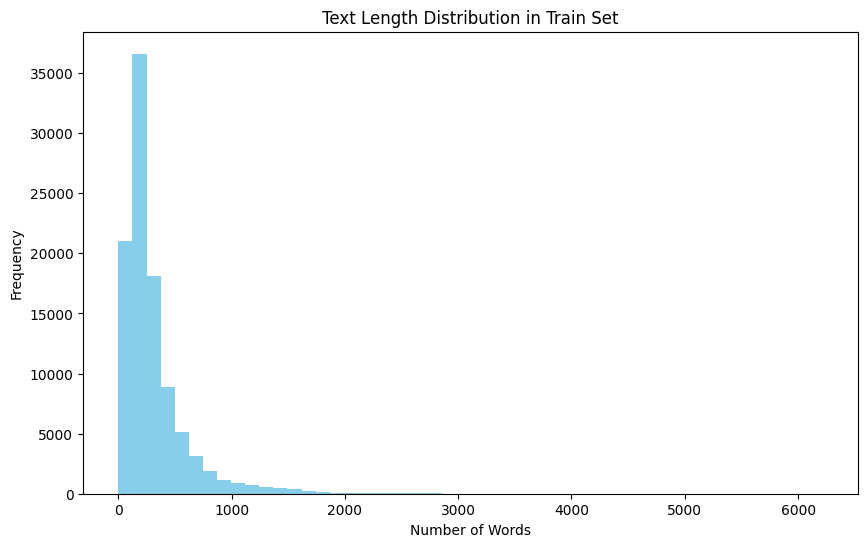

In [7]:
# Text Length Distribution (train set)
train_text_lengths = [len(text.split()) for text in train_data]
print(f"Average text length in train set: {sum(train_text_lengths) / len(train_text_lengths)} words")
print("\n")
plt.figure(figsize=(10,6))
plt.hist(train_text_lengths, bins=50, color='skyblue')
plt.title('Text Length Distribution in Train Set')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

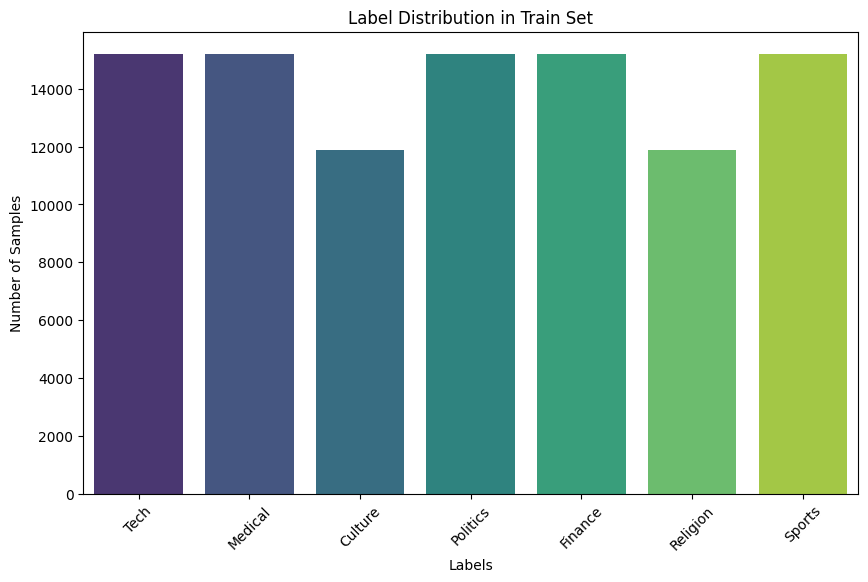

In [8]:
from collections import Counter

# Label Distribution (train set)
train_label_counts = Counter(train_labels)
labels, counts = zip(*train_label_counts.items())

plt.figure(figsize=(10,6))
sns.barplot(x=labels, y=counts, hue=labels, palette='viridis', legend=False)
plt.title('Label Distribution in Train Set')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Sample Texts from each category
for label in set(train_labels):
    print(f"Sample text from {label}:")
    sample_text = next(text for text, label_ in zip(train_data, train_labels) if label_ == label)
    print(sample_text[:500])  # Print first 500 characters of the sample
    print('-' * 80)

Sample text from Religion:
Title
طرائف من التراث العربي:  ذم البخلاء يوم الأربعاء

Body
من الأشعار الجميلة التي قيلت في ذم بخلاء الصائمين قول الشاعر:
اتيت قيصر سحراً فقال اني صائم
فقلت اني قاعد فقال إني قائم
فقلت آتيك غدا فقال صومي دائم
ومن ذلك ما قال ابو نواس يهجو الفضل قائلا:
رأيت الفضل مكتئبا يناغي الخبز والسمكا
فأسبل دمعة لما رآني قادما وبكى
فلما ان حلفت له بأني صائم ضحكا
اتى اصحاب مزبد يوما، فقالوا له: يا أبا اسحاق، هل لك في الخروج الى العقيق، والى قباء، والى احد ناحية قبور الشهداء، فإن يومنا كما ترى يوم طيب.
قال: ال
--------------------------------------------------------------------------------
Sample text from Tech:
Title
سبوتيفاي تتجاوز حاجز 100 مليون مستخدم نشط

Body
أكّدت شركة سبوتيفاي لصحيفة تيليغراف اليوم، أنها تجاوزت حاجز 100 مليون مستخدم نشط شهرياً، وذلك بعد ثلاثة أشهر من إعلان الشركة عن وصولها إلى 30 مليون مستخدم لديه اشتراك مدفوع في الخدمة الموسيقية الأشهر.وبحسب بنك الاستثمار GP Bullhound فإن سبوتيفاي سويدية الأصل أصبحت أيضاً أكبر شركة ناشئة في أوروبا، والتي قدّرت قيمت

#**3. Data Preprocessing**

In [10]:
import torch
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

In [11]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('aubmindlab/bert-base-arabertv2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

In [12]:
from tqdm import tqdm

MAX_LENGTH = 512  # Maximum length for BERT model input

# Tokenize the data with a progress bar
def tokenize_data_with_progress(texts):
    encodings = []
    # Use tqdm to create a progress bar over the dataset
    for text in tqdm(texts, desc="Tokenizing", unit="sample", ncols=100):
        encoding = tokenizer(
            text,
            add_special_tokens=True,  # Adds [CLS] and [SEP] tokens
            padding='max_length',     # Pads or truncates to the max length
            max_length=MAX_LENGTH,    # Set max length for padding
            truncation=True,          # Truncates text longer than max_length
            return_attention_mask=True,  # Returns attention mask
            return_tensors='pt'      # Returns PyTorch tensors
        )
        encodings.append(encoding)
    return encodings

# Tokenizing the train and test data with progress bar
train_encodings = tokenize_data_with_progress(train_data)
test_encodings = tokenize_data_with_progress(test_data)

Tokenizing: 100%|████████████████████████████████████████| 11090/11090 [01:37<00:00, 113.73sample/s]


In [13]:
# Initialize label encoder
label_encoder = LabelEncoder()

# Fit label encoder on train labels
label_encoder.fit(train_labels)

# Encoding the train labels with a progress bar
train_labels_encoded = []
for label in tqdm(train_labels, desc="Encoding train labels", unit="label", ncols=100):
    train_labels_encoded.append(label_encoder.transform([label])[0])

# Encoding the test labels with a progress bar
test_labels_encoded = []
for label in tqdm(test_labels, desc="Encoding test labels", unit="label", ncols=100):
    test_labels_encoded.append(label_encoder.transform([label])[0])

Encoding test labels: 100%|██████████████████████████████| 11090/11090 [00:01<00:00, 9305.46label/s]


In [14]:
# Convert tokenized train data (input_ids and attention_mask) to tensors with progress bars
train_inputs = []
for encoding in tqdm(train_encodings, desc="Converting train data to tensors", unit="sample", ncols=100):
    train_inputs.append(torch.tensor(encoding['input_ids'])) # Access 'input_ids' from the dictionary
train_inputs = torch.stack(train_inputs)

train_attention_mask = []
for encoding in tqdm(train_encodings, desc="Converting train attention masks to tensors", unit="sample", ncols=100):
    train_attention_mask.append(torch.tensor(encoding['attention_mask'])) # Access 'attention_mask' from the dictionary
train_attention_mask = torch.stack(train_attention_mask)

# Convert tokenized test data (input_ids and attention_mask) to tensors with progress bars
test_inputs = []
for encoding in tqdm(test_encodings, desc="Converting test data to tensors", unit="sample", ncols=100):
    test_inputs.append(torch.tensor(encoding['input_ids'])) # Access 'input_ids' from the dictionary
test_inputs = torch.stack(test_inputs)

test_attention_mask = []
for encoding in tqdm(test_encodings, desc="Converting test attention masks to tensors", unit="sample", ncols=100):
    test_attention_mask.append(torch.tensor(encoding['attention_mask'])) # Access 'attention_mask' from the dictionary
test_attention_mask = torch.stack(test_attention_mask)

# Convert encoded labels into tensors
train_labels_tensor = torch.tensor(train_labels_encoded)
test_labels_tensor = torch.tensor(test_labels_encoded)

Converting train data to tensors:   0%|                               | 0/99810 [00:00<?, ?sample/s]<ipython-input-14-06ac987eef5c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs.append(torch.tensor(encoding['input_ids'])) # Access 'input_ids' from the dictionary
Converting train attention masks to tensors:   0%|                    | 0/99810 [00:00<?, ?sample/s]<ipython-input-14-06ac987eef5c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_attention_mask.append(torch.tensor(encoding['attention_mask'])) # Access 'attention_mask' from the dictionary
Converting test data to tensors:   0%|                                | 0/11090 [00:00<?, ?sample/s]<ipython-input-14-06

In [15]:
print(f"Train input_ids shape: {train_inputs.shape}")  # Should be (num_train_samples, 512)
print(f"Train attention_mask shape: {train_attention_mask.shape}")  # Should be (num_train_samples, 512)
print(f"Train labels shape: {train_labels_tensor.shape}")  # Should be (num_train_samples,)

print(f"Test input_ids shape: {test_inputs.shape}")  # Should be (num_test_samples, 512)
print(f"Test attention_mask shape: {test_attention_mask.shape}")  # Should be (num_test_samples, 512)
print(f"Test labels shape: {test_labels_tensor.shape}")  # Should be (num_test_samples,)

Train input_ids shape: torch.Size([99810, 1, 512])
Train attention_mask shape: torch.Size([99810, 1, 512])
Train labels shape: torch.Size([99810])
Test input_ids shape: torch.Size([11090, 1, 512])
Test attention_mask shape: torch.Size([11090, 1, 512])
Test labels shape: torch.Size([11090])


In [16]:
# Remove the extra dimension
train_inputs = train_inputs.squeeze(1)
train_attention_mask = train_attention_mask.squeeze(1)

test_inputs = test_inputs.squeeze(1)
test_attention_mask = test_attention_mask.squeeze(1)

# Check the shapes again
print(f"Train input_ids shape: {train_inputs.shape}")
print(f"Train attention_mask shape: {train_attention_mask.shape}")
print(f"Train labels shape: {train_labels_tensor.shape}")

print(f"Test input_ids shape: {test_inputs.shape}")
print(f"Test attention_mask shape: {test_attention_mask.shape}")
print(f"Test labels shape: {test_labels_tensor.shape}")

Train input_ids shape: torch.Size([99810, 512])
Train attention_mask shape: torch.Size([99810, 512])
Train labels shape: torch.Size([99810])
Test input_ids shape: torch.Size([11090, 512])
Test attention_mask shape: torch.Size([11090, 512])
Test labels shape: torch.Size([11090])


In [17]:
# Create TensorDatasets for training and testing
train_dataset = TensorDataset(train_inputs, train_attention_mask, train_labels_tensor)
test_dataset = TensorDataset(test_inputs, test_attention_mask, test_labels_tensor)

### Data Preprocessing Summary

In this section, we have completed the essential preprocessing steps to prepare the SANAD dataset for fine-tuning with BERT. The steps we followed are:

1. **Loading the Data:**
   - We loaded the dataset from the SANAD_SUBSET.zip file, which consists of three subsets: Akhbarona, Khaleej, and Arabiya.
   - The dataset contains both training and testing data for each subset, and we merged the data from all subsets into one unified dataset.

2. **Exploratory Data Analysis (EDA):**
   - We examined the dataset by analyzing the number of samples, the distribution of labels, and the text length distribution in the training set.
   - We also printed sample texts from each category to better understand the data and ensure that all categories are well-represented.

3. **Tokenization:**
   - Using the pre-trained `aubmindlab/bert-base-arabertv2` tokenizer, we tokenized the raw text data from both the training and testing sets.
   - The tokenization process converts text into numerical tokens that the BERT model can understand, adding special tokens such as `[CLS]` and `[SEP]` and padding or truncating sequences to a fixed length of 512 tokens.

4. **Label Encoding:**
   - We used `LabelEncoder` from scikit-learn to convert categorical labels (e.g., "Tech", "Medical", etc.) into numeric labels.
   - This ensures that the model can work with numerical labels during training and evaluation.

5. **Conversion to Tensors:**
   - After tokenizing the text and encoding the labels, we converted all data into PyTorch tensors.
   - Tensors are the fundamental data structure used by PyTorch models, so this step prepares the data for efficient training and evaluation in the BERT model.

6. **Dataset Creation:**
   - Finally, we created `TensorDataset` objects for both the training and testing sets. These datasets hold the tokenized inputs (input IDs and attention masks) along with the corresponding labels, ready to be fed into the model.

### Purpose of Preprocessing in This Task

The purpose of this preprocessing pipeline is to transform the raw text data and labels into a format that can be directly used for training and testing a BERT-based model. Here's why each step is important:

- **Tokenization**: BERT cannot process raw text directly. We need to convert text into tokens (numerical representations) that the model can understand. Tokenization ensures that the model receives input in a consistent and structured format.
  
- **Label Encoding**: Machine learning models require numerical labels for classification tasks. By encoding the categorical labels as numbers, we enable the model to predict labels in a numerical form during training.

- **Tensor Conversion**: PyTorch models work with tensors, not raw data. Converting the tokenized text and labels into tensors is necessary for the model to handle and process the data efficiently during training.

- **Dataset Creation**: Creating a `TensorDataset` allows for easy batching of data during training, which is crucial for efficient model training on large datasets.

With these preprocessing steps completed, we are now ready to proceed to fine-tune the BERT model on our text classification task.

### Next Steps
The next phase will involve setting up the BERT model for training, creating data loaders, and then fine-tuning the model on our dataset.

# **4. Fine-Tune BERT on Training Dataset**

In [18]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 16.9 MB/s eta 0:00:00


In [19]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [20]:
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from torchmetrics.classification import Accuracy

In [21]:
from datasets import Dataset

# Adding progress bar for constructing the train_data_dict
train_data_dict = {
    'input_ids': [input for input in tqdm(train_inputs, desc='Processing train inputs')],
    'attention_mask': [mask for mask in tqdm(train_attention_mask, desc='Processing train masks')],
    'labels': [label.item() for label in tqdm(train_labels_tensor, desc='Processing train labels')]
}

# Adding progress bar for constructing the test_data_dict
test_data_dict = {
    'input_ids': [input for input in tqdm(test_inputs, desc='Processing test inputs')],
    'attention_mask': [mask for mask in tqdm(test_attention_mask, desc='Processing test masks')],
    'labels': [label.item() for label in tqdm(test_labels_tensor, desc='Processing test labels')]
}

# Create datasets from the dictionary
train_dataset = Dataset.from_dict(train_data_dict)
test_dataset = Dataset.from_dict(test_data_dict)

Processing test labels: 100%|██████████| 11090/11090 [00:00<00:00, 247085.49it/s]


In [22]:
import numpy as np
from datasets import Dataset

# Define a function to balance the dataset
def balance_dataset(dataset, labels_column='labels', num_samples_per_class=2857):  # 2857 = 20,000 // 7
    balanced_data = []
    # Get the unique labels in the dataset
    unique_labels = np.unique(dataset[labels_column])

    # For each label, sample 'num_samples_per_class' rows
    for label in unique_labels:
        label_rows = dataset.filter(lambda x: x[labels_column] == label)
        sampled_rows = label_rows.shuffle(seed=42).select(range(num_samples_per_class))
        balanced_data.append(sampled_rows)

    # Concatenate the balanced data
    balanced_dataset = Dataset.from_dict({
        key: [item for sublist in [data[key] for data in balanced_data] for item in sublist]
        for key in dataset.features
    })

    return balanced_dataset

# Balance the training dataset
balanced_train_dataset = balance_dataset(train_dataset, labels_column='labels', num_samples_per_class=2857)

# Optionally, balance the test dataset (you can adjust the size for test data if needed)
balanced_test_dataset = balance_dataset(test_dataset, labels_column='labels', num_samples_per_class=714)

Filter:   0%|          | 0/99810 [00:00<?, ? examples/s]

Filter:   0%|          | 0/99810 [00:00<?, ? examples/s]

Filter:   0%|          | 0/99810 [00:00<?, ? examples/s]

Filter:   0%|          | 0/99810 [00:00<?, ? examples/s]

Filter:   0%|          | 0/99810 [00:00<?, ? examples/s]

Filter:   0%|          | 0/99810 [00:00<?, ? examples/s]

Filter:   0%|          | 0/99810 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11090 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11090 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11090 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11090 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11090 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11090 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11090 [00:00<?, ? examples/s]

In [23]:
from collections import Counter

# Function to check class distribution in the dataset
def check_class_distribution(dataset, labels_column='labels'):
    labels = dataset[labels_column]
    label_counts = Counter(labels)
    return label_counts

# Check the class distribution in the balanced training dataset
train_class_distribution = check_class_distribution(balanced_train_dataset, labels_column='labels')
print("Training Dataset Class Distribution:", train_class_distribution)

# Check the class distribution in the balanced test dataset
test_class_distribution = check_class_distribution(balanced_test_dataset, labels_column='labels')
print("Test Dataset Class Distribution:", test_class_distribution)

Training Dataset Class Distribution: Counter({0: 2857, 1: 2857, 2: 2857, 3: 2857, 4: 2857, 5: 2857, 6: 2857})
Test Dataset Class Distribution: Counter({0: 714, 1: 714, 2: 714, 3: 714, 4: 714, 5: 714, 6: 714})


In [24]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('aubmindlab/bert-base-arabertv2', num_labels=len(label_encoder.classes_))

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import TrainingArguments

# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./results',               # Output directory for saving results
    evaluation_strategy="epoch",          # Evaluate after every epoch
    learning_rate=2e-5,                   # Learning rate
    per_device_train_batch_size=16,       # Batch size for training
    per_device_eval_batch_size=16,        # Batch size for evaluation
    num_train_epochs=3,                   # Number of epochs
    weight_decay=0.01,                    # Weight decay for regularization
    logging_dir='./logs',                 # Directory for logging
    logging_steps=10,                     # Log every 10 steps
    report_to="tensorboard",              # Report to TensorBoard for visualizing training process
    load_best_model_at_end=True,          # Load the best model at the end of training
    metric_for_best_model="accuracy",     # Metric for determining the best model
    save_strategy="epoch",                # Save the model at the end of each epoch
    disable_tqdm=False,                   # Enable tqdm progress bar
    fp16=True,                            # Enable mixed precision training
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00


In [27]:
from transformers import default_data_collator

# Use default data collator
data_collator = default_data_collator

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=balanced_train_dataset,
    eval_dataset=balanced_test_dataset,
    data_collator=data_collator,  # Use the default collator
    compute_metrics=lambda p: {'accuracy': Accuracy(task="multiclass", num_classes=7)(torch.tensor(p.predictions).argmax(axis=1), torch.tensor(p.label_ids))},
)

In [28]:
# Start training the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.074600,0.158114,0.958183
2,0.138100,0.174196,0.958984
3,0.058800,0.158768,0.964786


TrainOutput(global_step=3750, training_loss=0.15726685173511504, metrics={'train_runtime': 1715.9613, 'train_samples_per_second': 34.964, 'train_steps_per_second': 2.185, 'total_flos': 1.57865826633984e+16, 'train_loss': 0.15726685173511504, 'epoch': 3.0})

In [29]:
# Evaluate the model
eval_results = trainer.evaluate(eval_dataset=balanced_test_dataset)
print("Evaluation results:", eval_results)

Evaluation results: {'eval_loss': 0.15876777470111847, 'eval_accuracy': 0.9647859334945679, 'eval_runtime': 37.3566, 'eval_samples_per_second': 133.792, 'eval_steps_per_second': 8.379, 'epoch': 3.0}


In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Specify a directory to save your model
save_directory = "./trained_model_pipeline"

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

('./trained_model_pipeline/tokenizer_config.json',
 './trained_model_pipeline/special_tokens_map.json',
 './trained_model_pipeline/vocab.txt',
 './trained_model_pipeline/added_tokens.json')

In [31]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the saved model and tokenizer
loaded_model = AutoModelForSequenceClassification.from_pretrained(save_directory)
loaded_tokenizer = AutoTokenizer.from_pretrained(save_directory)

In [32]:
from transformers import pipeline

# Create a text classification pipeline
text_classification_pipeline = pipeline("text-classification", model=loaded_model, tokenizer=loaded_tokenizer)

Device set to use cuda:0


In [33]:
print("Label Mapping:")
for index, label in enumerate(label_encoder.classes_):
    print(f"{index}: {label}")

Label Mapping:
0: Culture
1: Finance
2: Medical
3: Politics
4: Religion
5: Sports
6: Tech


In [34]:
# Define the mapping of label ids to category names
label_map = {
    0: 'Culture',
    1: 'Finance',
    2: 'Medical',
    3: 'Politics',
    4: 'Religion',
    5: 'Sports',
    6: 'Tech'
}

# Update the model's config with this new mapping
model.config.id2label = label_map
model.config.label2id = {v: k for k, v in label_map.items()}

# Now, you can use the model's predictions with the updated labels

In [35]:
print(model.config.label2id)
print(model.config.id2label)

{'Culture': 0, 'Finance': 1, 'Medical': 2, 'Politics': 3, 'Religion': 4, 'Sports': 5, 'Tech': 6}
{0: 'Culture', 1: 'Finance', 2: 'Medical', 3: 'Politics', 4: 'Religion', 5: 'Sports', 6: 'Tech'}


In [36]:
# Define the label mapping
label_mapping = {
    0: 'Culture',
    1: 'Finance',
    2: 'Medical',
    3: 'Politics',
    4: 'Religion',
    5: 'Sports',
    6: 'Tech'
}

# Hardcoded test data with expected labels
test_articles = [
    ("افتتحت شركة آبل اليوم أحدث متاجرها في دبي وسط حضور جماهيري كبير.", "Tech"),  # Expected: Tech
    ("حقق فريق ريال مدريد فوزًا مثيرًا على برشلونة في مباراة الكلاسيكو.", "Sports"),  # Expected: Sports
    ("أعلنت وزارة الصحة عن حملة جديدة للتوعية بأهمية التطعيم ضد الأمراض المعدية.", "Medical"),  # Expected: Health
    ("شهدت البورصة العالمية انخفاضًا كبيرًا في أسهم التكنولوجيا هذا الأسبوع.", "Finance"),  # Expected: Finance
    ("اختتم مهرجان كان السينمائي فعالياته بحضور نجوم عالميين.", "Culture"),  # Expected: Culture
]

# Get predictions using the text classification pipeline
predictions = text_classification_pipeline([article[0] for article in test_articles])

# Print results with expected output, predicted output, and confidence
for idx, (article, expected_label) in enumerate(test_articles):
    predicted_label_id = predictions[idx]['label']
    confidence = predictions[idx]['score']

    # Map the label ID to the actual label name using the label_mapping dictionary
    predicted_label = label_mapping[int(predicted_label_id.split('_')[1])]  # Extract number from LABEL_X

    print(f"Article: {article}")
    print(f"Expected Label: {expected_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence: {confidence:.4f}")
    print("-" * 50)

Article: افتتحت شركة آبل اليوم أحدث متاجرها في دبي وسط حضور جماهيري كبير.
Expected Label: Tech
Predicted Label: Tech
Confidence: 0.9967
--------------------------------------------------
Article: حقق فريق ريال مدريد فوزًا مثيرًا على برشلونة في مباراة الكلاسيكو.
Expected Label: Sports
Predicted Label: Sports
Confidence: 0.9986
--------------------------------------------------
Article: أعلنت وزارة الصحة عن حملة جديدة للتوعية بأهمية التطعيم ضد الأمراض المعدية.
Expected Label: Medical
Predicted Label: Medical
Confidence: 0.9507
--------------------------------------------------
Article: شهدت البورصة العالمية انخفاضًا كبيرًا في أسهم التكنولوجيا هذا الأسبوع.
Expected Label: Finance
Predicted Label: Finance
Confidence: 0.9976
--------------------------------------------------
Article: اختتم مهرجان كان السينمائي فعالياته بحضور نجوم عالميين.
Expected Label: Culture
Predicted Label: Culture
Confidence: 0.9972
--------------------------------------------------


In [37]:
# Hardcoded test data with actual expected labels in name format
test_articles = [
    {
        "article": "شهدت السنوات الأخيرة تطورًا سريعًا في مجال الذكاء الاصطناعي، حيث أظهرت العديد من التطبيقات الحديثة قدرات غير مسبوقة في تحليل البيانات واتخاذ القرارات بشكل شبه مستقل. في عالم التكنولوجيا، أصبحت الذكاء الاصطناعي جزءًا أساسيًا من العديد من الصناعات مثل الرعاية الصحية، والسيارات الذاتية القيادة، وتحليل البيانات الضخمة. على سبيل المثال، أصبح بإمكان تطبيقات الذكاء الاصطناعي مثل المساعدات الصوتية، من خلال فهم اللغة الطبيعية، أن تساعد في تحسين تجربة المستخدم بشكل كبير. بالإضافة إلى ذلك، يتوقع الخبراء أن يكون للذكاء الاصطناعي دور محوري في حل بعض من أكبر التحديات التي يواجهها المجتمع، مثل التغير المناخي والطب. لكن، ومع هذه الفوائد الهائلة، يثير الذكاء الاصطناعي أيضًا العديد من الأسئلة الأخلاقية المتعلقة بالخصوصية والأمان والتأثير على سوق العمل.",
        "expected_label": "Technology"
    },
    {
        "article": "تعد كرة القدم من أكثر الرياضات شعبية في العالم، حيث يتابعها الملايين من المشجعين عبر مختلف القارات. في الآونة الأخيرة، أصبح الدوري الإنجليزي الممتاز هو البطولة الأكثر مشاهدة في العالم بفضل تطور الفرق واللاعبين، بالإضافة إلى الاستثمارات الكبيرة التي شهدتها الأندية. من بين الأندية الشهيرة في الدوري الإنجليزي، يعتبر فريق مانشستر سيتي من أبرز الفرق التي نجحت في السنوات الأخيرة في حصد العديد من الألقاب المحلية والدولية، تحت قيادة المدرب بيب غوارديولا. وقد أصبح الفريق معروفًا بأسلوب لعبه الممتع والهجومي، مما جذب العديد من المتابعين من جميع أنحاء العالم. كما أن هناك العديد من النجوم مثل كيفين دي بروين وسيرجيو أغويرو الذين أصبحوا من الأيقونات العالمية في كرة القدم.",
        "expected_label": "Sports"
    },
    {
        "article": "تعتبر الرعاية الصحية من أهم الجوانب التي تؤثر بشكل مباشر على جودة الحياة، وقد شهدت تحسنًا كبيرًا في السنوات الأخيرة بفضل التقدم الطبي والتكنولوجي. تساهم التقنيات الحديثة مثل الذكاء الاصطناعي والروبوتات في تحسين دقة التشخيص والعلاج. من أبرز التحولات التي نشهدها في هذا المجال هو استخدام الذكاء الاصطناعي في اكتشاف الأمراض في مراحل مبكرة، مثل السرطان والأمراض القلبية. وتعمل المستشفيات اليوم على دمج هذه التقنيات الحديثة مع الرعاية التقليدية لتحقيق أفضل النتائج للمرضى. بالإضافة إلى ذلك، أصبح العلاج عن بُعد ممكنًا بفضل الإنترنت والتطبيقات الطبية، مما يسهل الوصول إلى الأطباء المتخصصين حتى في المناطق النائية. بالرغم من هذه التحديات، إلا أن هناك أيضًا قلقًا متزايدًا بشأن استخدام البيانات الطبية وكيفية حمايتها من التسريب.",
        "expected_label": "Medical"
    },
    {
        "article": "يواجه الاقتصاد العالمي العديد من التحديات في الوقت الراهن، خاصة في ظل الأزمة الاقتصادية العالمية التي تسببت فيها جائحة كوفيد-19. فقد تضررت الأسواق المالية بشكل كبير نتيجة للركود الاقتصادي، مما أدى إلى انخفاض أسعار الأسهم في العديد من الشركات الكبرى. ومع بداية التعافي، أصبح من الواضح أن هناك حاجة ملحة لإصلاح النظام المالي لضمان استدامة الاقتصاد. في هذا السياق، بدأ العديد من الخبراء الماليين في دراسة دور العملات الرقمية مثل البيتكوين والإيثيريوم في تغيير المشهد المالي العالمي. العملات الرقمية تقدم إمكانيات كبيرة في تسريع المعاملات وتقليل التكاليف، ولكنها في الوقت نفسه تثير مخاوف من تقلبات الأسعار والمخاطر المرتبطة بالاختراقات الإلكترونية. ومن هنا، أصبح التنسيق بين الحكومات والبنوك المركزية أمرًا ضروريًا لتنظيم هذه العملات وحمايتها من المخاطر.",
        "expected_label": "Finance"
    },
    {
        "article": "تعتبر الثقافة جزءًا لا يتجزأ من هوية الشعوب، وتشمل العديد من الجوانب مثل الفنون والآداب والموسيقى والسينما. في العالم العربي، يعتبر الأدب العربي من أغنى وأعرق الأدبيات في التاريخ، حيث ساهم العديد من الكتاب والشعراء في إثراء الثقافة العالمية. من أبرز هؤلاء الشعراء هو نزار قباني، الذي يعد من أشهر شعراء الحب في العصر الحديث، وقد تركت قصائده تأثيرًا كبيرًا في العديد من الأجيال. وفي مجال السينما، أصبح للفن السابع دورًا محوريًا في نقل ثقافة الشعوب وتعريف العالم بعاداتهم وتقاليدهم. في السنوات الأخيرة، شهدت السينما العربية تطورًا ملحوظًا، مع تقديم أفلام تهتم بالقضايا الاجتماعية والسياسية وتعرض قصصًا واقعية عن التحديات التي تواجه المجتمعات. كما أن هناك أيضًا اهتمامًا متزايدًا بالفنون التشكيلية، حيث يعرض العديد من الفنانين المعاصرين أعمالًا تمثل مزيجًا من التراث والحداثة.",
        "expected_label": "Culture"
    }
]

# Label mapping (same as your model's config)
label_mapping = {
    0: 'Culture',
    1: 'Finance',
    2: 'Medical',
    3: 'Politics',
    4: 'Religion',
    5: 'Sports',
    6: 'Technology'
}

# Get predictions
predictions = text_classification_pipeline([item["article"] for item in test_articles])

# Print results
for idx, item in enumerate(test_articles):
    predicted_label_idx = int(predictions[idx]['label'].split('_')[1])  # Extract the number from 'LABEL_x'
    predicted_label = label_mapping[predicted_label_idx]  # Map the number to the label name

    print(f"Article: {item['article']}")
    print(f"Expected Label: {item['expected_label']}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence: {predictions[idx]['score']:.4f}")
    print("-" * 50)

Article: شهدت السنوات الأخيرة تطورًا سريعًا في مجال الذكاء الاصطناعي، حيث أظهرت العديد من التطبيقات الحديثة قدرات غير مسبوقة في تحليل البيانات واتخاذ القرارات بشكل شبه مستقل. في عالم التكنولوجيا، أصبحت الذكاء الاصطناعي جزءًا أساسيًا من العديد من الصناعات مثل الرعاية الصحية، والسيارات الذاتية القيادة، وتحليل البيانات الضخمة. على سبيل المثال، أصبح بإمكان تطبيقات الذكاء الاصطناعي مثل المساعدات الصوتية، من خلال فهم اللغة الطبيعية، أن تساعد في تحسين تجربة المستخدم بشكل كبير. بالإضافة إلى ذلك، يتوقع الخبراء أن يكون للذكاء الاصطناعي دور محوري في حل بعض من أكبر التحديات التي يواجهها المجتمع، مثل التغير المناخي والطب. لكن، ومع هذه الفوائد الهائلة، يثير الذكاء الاصطناعي أيضًا العديد من الأسئلة الأخلاقية المتعلقة بالخصوصية والأمان والتأثير على سوق العمل.
Expected Label: Technology
Predicted Label: Technology
Confidence: 0.9981
--------------------------------------------------
Article: تعد كرة القدم من أكثر الرياضات شعبية في العالم، حيث يتابعها الملايين من المشجعين عبر مختلف القارات. في الآونة ال

#5. DIFFERENTIAL ATTENTION MECHANISM

In [38]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class DifferentialAttention(nn.Module):
    def __init__(self, d_model, d, n_heads, device, lambda_init=0.8):
        super(DifferentialAttention, self).__init__()
        self.d_model = d_model
        self.d = d
        self.n_heads = n_heads
        self.device = device
        self.lambda_init = lambda_init

        # Learnable vectors for λq1, λk1, λq2, λk2
        self.lambda_q1 = nn.Parameter(torch.randn(d, device=device))  # Vector
        self.lambda_k1 = nn.Parameter(torch.randn(d, device=device))  # Vector
        self.lambda_q2 = nn.Parameter(torch.randn(d, device=device))  # Vector
        self.lambda_k2 = nn.Parameter(torch.randn(d, device=device))  # Vector

        # Linear layers to generate Q1, Q2, K1, K2, and V
        self.WQ = nn.Linear(d_model, 2 * d * n_heads, device=device)
        self.WK = nn.Linear(d_model, 2 * d * n_heads, device=device)
        self.WV = nn.Linear(d_model, 2 * d * n_heads, device=device)

    def forward(self, X):
        """
        X: Input tensor of shape (N, d_model) where N is the sequence length
        """
        # Step 1: Compute Q1, Q2, K1, K2, and V
        Q = self.WQ(X)  # (N, 2 * d * n_heads)
        K = self.WK(X)  # (N, 2 * d * n_heads)
        V = self.WV(X)  # (N, 2 * d * n_heads)

        # Split Q, K into Q1, Q2, K1, K2
        Q1, Q2 = Q.chunk(2, dim=-1)
        K1, K2 = K.chunk(2, dim=-1)

        # Compute λ using the formula with learnable vectors
        lambda_val = torch.exp(torch.dot(self.lambda_q1, self.lambda_k1)) - \
                     torch.exp(torch.dot(self.lambda_q2, self.lambda_k2)) + \
                     self.lambda_init

        # Step 2: Compute the differential attention (with separate softmax)
        attention_q1 = F.softmax(torch.matmul(Q1, K1.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d).float()), dim=-1)
        attention_q2 = F.softmax(torch.matmul(Q2, K2.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d).float()), dim=-1)

        # Step 3: Apply differential attention
        attention = attention_q1 - lambda_val * attention_q2

        # Step 4: Compute the weighted sum of values using the attention scores
        out = torch.matmul(attention, V)

        return out

class MultiHeadDifferentialAttention(nn.Module):
    def __init__(self, d_model, d, n_heads, device):
        super(MultiHeadDifferentialAttention, self).__init__()
        self.device = device
        self.d_model = d_model
        self.d = d  # head_dim
        self.n_heads = n_heads

        # Ensure d_model is divisible by n_heads for correct head_dim calculation
        assert d_model % n_heads == 0, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        self.head_dim = d_model // n_heads

        self.query = nn.Linear(d_model, d_model, device=device)  # Project to d_model for all heads
        self.key = nn.Linear(d_model, d_model, device=device)    # Project to d_model for all heads
        self.value = nn.Linear(d_model, d_model, device=device)  # Project to d_model for all heads
        self.out = nn.Linear(d_model, d_model, device=device)

        # Learnable vectors for λq1, λk1, λq2, λk2
        self.lambda_q1 = nn.Parameter(torch.randn(self.head_dim, device=device))
        self.lambda_k1 = nn.Parameter(torch.randn(self.head_dim, device=device))
        self.lambda_q2 = nn.Parameter(torch.randn(self.head_dim, device=device))
        self.lambda_k2 = nn.Parameter(torch.randn(self.head_dim, device=device))
        self.lambda_init = 0.8  # Initial value for lambda

    def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None, past_key_value=None, output_attentions=False):
        batch_size, seq_len, _ = hidden_states.size()

        # Project input to query, key, and value using linear layers
        query = self.query(hidden_states)
        key = self.key(hidden_states)
        value = self.value(hidden_states)

        # Reshape query, key, and value for multi-head attention
        query = query.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_dim)
        key = key.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        value = value.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)

        # Split Q, K into Q1, Q2, K1, K2 along the head_dim
        Q1, Q2 = query.chunk(2, dim=-1)
        K1, K2 = key.chunk(2, dim=-1)

        # Compute λ using the formula with learnable vectors
        lambda_val = torch.exp(torch.dot(self.lambda_q1, self.lambda_k1)) - \
                     torch.exp(torch.dot(self.lambda_q2, self.lambda_k2)) + \
                     self.lambda_init

        # Compute differential attention (with separate softmax)
        attention_q1 = F.softmax(torch.matmul(Q1, K1.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim / 2).float().to(self.device)), dim=-1)
        attention_q2 = F.softmax(torch.matmul(Q2, K2.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim / 2).float().to(self.device)), dim=-1)

        # Apply differential attention
        attention = attention_q1 - lambda_val * attention_q2

        # Compute the weighted sum of values using the attention scores
        attention_output = torch.matmul(attention, value)

        # Reshape attention_output back to original shape
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.head_dim * self.n_heads)

        # Project attention_output back to d_model dimensions
        attention_output = self.out(attention_output)

        # Return a tuple as expected by BertSelfAttention
        return (attention_output,)

### Number of layers

In [39]:
num_layers = len(model.bert.encoder.layer)
print(f"Number of layers in the encoder: {num_layers}")

Number of layers in the encoder: 12


### We compute evaluation metrics for the Trainer.

In [40]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes evaluation metrics for the Trainer.

    Args:
        pred: A PredictionOutput object containing predictions and labels.

    Returns:
        A dictionary of metrics including accuracy, precision, recall, and F1-score.
    """
    # Extract predictions and labels
    logits, labels = pred.predictions, pred.label_ids
    predictions = logits.argmax(axis=-1)  # Get the class with the highest probability

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    # Return metrics as a dictionary
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


### Modify the Fine-Tuned BERT Model

In [42]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

# Load the fine-tuned model and tokenizer
save_directory = "./trained_model_pipeline"
model = AutoModelForSequenceClassification.from_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(save_directory)

# Ensure the model is moved to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get the number of layers in BERT's encoder
num_layers = len(model.bert.encoder.layer)

# Function to replace attention with differential attention in a range of layers
def replace_attention(model, start_layer, end_layer):
    for i in range(start_layer, end_layer):
        model.bert.encoder.layer[i].attention.self = MultiHeadDifferentialAttention(
            d_model=model.config.hidden_size,
            d=model.config.attention_probs_dropout_prob,
            n_heads=model.config.num_attention_heads,
            device=device
        ).to(device)

# Define the 50% configuration
ratio = 0.5
start_layer = 0
end_layer = int(ratio * num_layers)

print(f"Replacing layers {start_layer} to {end_layer} with differential attention...")

# Replace attention layers in the range
replace_attention(model, start_layer, end_layer)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_ratio_50",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_ratio_50",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    fp16=torch.cuda.is_available()
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=balanced_train_dataset,  # Ensure this is your fine-tuning dataset
    eval_dataset=balanced_test_dataset,   # Ensure this is your evaluation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Your custom metric function
)

# Fine-tune the model
print(f"Training model with 50% differential attention layers...")
trainer.train()

# Save the model
trainer.save_model("./trained_model_ratio_50")
tokenizer.save_pretrained("./trained_model_ratio_50")

# Evaluate the model
print(f"Evaluating model with 50% differential attention layers...")
metrics = trainer.evaluate()
print(metrics)

Replacing layers 0 to 6 with differential attention...
Training model with 50% differential attention layers...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-42-7e300d9b4f29>:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.498600,0.391620,0.890356,0.900612,0.890356,0.892016
2,0.274000,0.284900,0.923970,0.924674,0.923970,0.923627
3,0.141700,0.285890,0.933173,0.933228,0.933173,0.932976


Evaluating model with 50% differential attention layers...


{'eval_loss': 0.28589001297950745, 'eval_accuracy': 0.933173269307723, 'eval_precision': 0.9332276312582647, 'eval_recall': 0.933173269307723, 'eval_f1': 0.9329763989796926, 'eval_runtime': 60.492, 'eval_samples_per_second': 82.622, 'eval_steps_per_second': 5.174, 'epoch': 3.0}


## TEST THE MODEL

In [43]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import torch

# Configuration for testing a single model
model_path = "./trained_model_ratio_50"  # Path to the model with 50% differential attention
percent_replaced = 50  # Specify the percentage of layers replaced

In [44]:
# Hardcoded test data with expected labels
test_articles = [
    {
        "article": "شهدت السنوات الأخيرة تطورًا سريعًا في مجال الذكاء الاصطناعي...",
        "expected_label": "Technology"
    },
    {
        "article": "تعد كرة القدم من أكثر الرياضات شعبية في العالم...",
        "expected_label": "Sports"
    },
    {
        "article": "تعتبر الرعاية الصحية من أهم الجوانب التي تؤثر بشكل مباشر على جودة الحياة...",
        "expected_label": "Medical"
    },
    {
        "article": "يواجه الاقتصاد العالمي العديد من التحديات في الوقت الراهن...",
        "expected_label": "Finance"
    },
    {
        "article": "تعتبر الثقافة جزءًا لا يتجزأ من هوية الشعوب...",
        "expected_label": "Culture"
    }
]

# Label mapping (same as your model's config)
label_mapping = {
    0: 'Culture',
    1: 'Finance',
    2: 'Medical',
    3: 'Politics',
    4: 'Religion',
    5: 'Sports',
    6: 'Technology'
}

### We test for each configuration

In [45]:
# Load the model and tokenizer
print(f"Testing model with {percent_replaced}% differential attention layers...")
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the pipeline
text_classification_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# Get predictions
predictions = text_classification_pipeline([item["article"] for item in test_articles])

# Print results
print(f"\nResults for model with {percent_replaced}% layers replaced:")
for idx, item in enumerate(test_articles):
    predicted_label_idx = int(predictions[idx]['label'].split('_')[1])  # Extract the number from 'LABEL_x'
    predicted_label = label_mapping[predicted_label_idx]  # Map the number to the label name

    print(f"Article: {item['article'][:100]}...")  # Print the first 100 characters for brevity
    print(f"Expected Label: {item['expected_label']}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence: {predictions[idx]['score']:.4f}")
    print("-" * 50)

Some weights of the model checkpoint at ./trained_model_ratio_50 were not used when initializing BertForSequenceClassification: ['bert.encoder.layer.0.attention.self.lambda_k1', 'bert.encoder.layer.0.attention.self.lambda_k2', 'bert.encoder.layer.0.attention.self.lambda_q1', 'bert.encoder.layer.0.attention.self.lambda_q2', 'bert.encoder.layer.0.attention.self.out.bias', 'bert.encoder.layer.0.attention.self.out.weight', 'bert.encoder.layer.1.attention.self.lambda_k1', 'bert.encoder.layer.1.attention.self.lambda_k2', 'bert.encoder.layer.1.attention.self.lambda_q1', 'bert.encoder.layer.1.attention.self.lambda_q2', 'bert.encoder.layer.1.attention.self.out.bias', 'bert.encoder.layer.1.attention.self.out.weight', 'bert.encoder.layer.2.attention.self.lambda_k1', 'bert.encoder.layer.2.attention.self.lambda_k2', 'bert.encoder.layer.2.attention.self.lambda_q1', 'bert.encoder.layer.2.attention.self.lambda_q2', 'bert.encoder.layer.2.attention.self.out.bias', 'bert.encoder.layer.2.attention.self.ou

Testing model with 50% differential attention layers...


Device set to use cuda:0



Results for model with 50% layers replaced:
Article: شهدت السنوات الأخيرة تطورًا سريعًا في مجال الذكاء الاصطناعي......
Expected Label: Technology
Predicted Label: Religion
Confidence: 0.8060
--------------------------------------------------
Article: تعد كرة القدم من أكثر الرياضات شعبية في العالم......
Expected Label: Sports
Predicted Label: Religion
Confidence: 0.8956
--------------------------------------------------
Article: تعتبر الرعاية الصحية من أهم الجوانب التي تؤثر بشكل مباشر على جودة الحياة......
Expected Label: Medical
Predicted Label: Religion
Confidence: 0.8740
--------------------------------------------------
Article: يواجه الاقتصاد العالمي العديد من التحديات في الوقت الراهن......
Expected Label: Finance
Predicted Label: Religion
Confidence: 0.4733
--------------------------------------------------
Article: تعتبر الثقافة جزءًا لا يتجزأ من هوية الشعوب......
Expected Label: Culture
Predicted Label: Culture
Confidence: 0.5105
------------------------------------------------

---

# FROM THE WeLoveNLP TEAM  

We've successfully completed this project and learned so much along the way! It was an incredible experience diving into the depths of language models, experimenting with fine-tuning techniques, and implementing cutting-edge mechanisms like differential attention.  

While the GPU-related challenges tested our patience at times, we persevered and managed to overcome them with teamwork and determination. This project has truly been a great journey of growth, learning, and innovation.  

We’re proud of what we’ve achieved and excited to take these skills forward to future endeavors! 🚀  

**- The WeLoveNLP Team (HajAyaLak)** ❤️
